In [0]:
import urllib
import json
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from keras.models import Sequential
from keras.layers import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt 
import seaborn as sns

In [150]:
# Get the dataset metadata by passing package_id to the package_search endpoint
# For example, to retrieve the metadata for this dataset:

url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/package_show"
params = { "id": "b68cb71b-44a7-4394-97e2-5d2f41462a5d"}
response = urllib.request.urlopen(url, data=bytes(json.dumps(params), encoding="utf-8"))
package = json.loads(response.read())
print(package)

{'help': 'https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/help_show?name=package_show', 'success': True, 'result': {'license_title': 'Open Government Licence – Toronto', 'owner_unit': None, 'relationships_as_object': [], 'topics': 'Transportation', 'owner_email': 'Andrew.Hutt@ttc.ca', 'excerpt': 'TTC Streetcar Delay Data', 'private': False, 'owner_division': 'Toronto Transit Commission', 'num_tags': 5, 'id': 'b68cb71b-44a7-4394-97e2-5d2f41462a5d', 'metadata_created': '2019-07-23T18:12:13.621158', 'refresh_rate': 'Monthly', 'title': 'TTC Streetcar Delay Data', 'license_url': 'https://open.toronto.ca/open-data-license/', 'state': 'active', 'information_url': None, 'license_id': 'open-government-licence-toronto', 'type': 'dataset', 'resources': [{'cache_last_updated': None, 'package_id': 'b68cb71b-44a7-4394-97e2-5d2f41462a5d', 'datastore_active': False, 'id': '146bfbda-8146-4ff8-b3dc-1eec3a5170fe', 'size': 12886, 'format': 'XLSX', 'state': 'active', 'hash': '', 'description':

In [0]:
#Read data from the given api, store in pandas dataframe for processing.
data = pd.DataFrame()

url = str(package["result"]["resources"][1]["url"])
data_2014 = pd.read_excel(url, sheet_name=None)

url = str(package["result"]["resources"][2]["url"])
data_2015 = pd.read_excel(url, sheet_name=None)

url = str(package["result"]["resources"][3]["url"])
data_2016 = pd.read_excel(url, sheet_name=None)

url = str(package["result"]["resources"][4]["url"])
data_2017 = pd.read_excel(url, sheet_name=None)

url = str(package["result"]["resources"][5]["url"])
data_2018 = pd.read_excel(url, sheet_name=None)

url = str(package["result"]["resources"][6]["url"])
data_2019 = pd.read_excel(url, sheet_name=None)

url = str(package["result"]["resources"][7]["url"])
data_2020 = pd.read_excel(url, sheet_name=None)

datasets = [data_2014,data_2015,data_2016,data_2017,data_2018,data_2019]

for sets in datasets:
  for df in sets.values():
        data = pd.concat([data,df], ignore_index=True, sort=False).drop_duplicates(keep=False)

In [152]:
data.head()

,Report Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle,Incident ID,Delay,Gap
0,2014-01-02,505,06:31:00,Thursday,Dundas and Roncesvalles,Late Leaving Garage,4.0,8.0,E/B,4018.0,NaN,NaN,NaN
1,2014-01-02,504,12:43:00,Thursday,King and Shaw,Utilized Off Route,20.0,22.0,E/B,4128.0,NaN,NaN,NaN
2,2014-01-02,501,14:01:00,Thursday,Kingston road and Bingham,Held By,13.0,19.0,W/B,4016.0,NaN,NaN,NaN
3,2014-01-02,504,14:22:00,Thursday,King St. and Roncesvalles Ave.,Investigation,7.0,11.0,W/B,4175.0,NaN,NaN,NaN
4,2014-01-02,504,16:42:00,Thursday,King and Bathurst,Utilized Off Route,3.0,6.0,E/B,4080.0,NaN,NaN,NaN


In [153]:
#Drop irrelevant columns
data = data.drop(['Gap', 'Incident ID', 'Vehicle', 'Location', 'Incident', 'Min Gap'], axis=1)
data.drop(data.index[77997:], axis=0, inplace=True)
data.describe(include='all')

,Report Date,Route,Time,Day,Min Delay,Direction,Delay
count,77997,77997.000000,77997,77997,74815.000000,77691,3105.000000
unique,2143,NaN,1444,7,NaN,100,NaN
top,2017-12-28 00:00:00,NaN,06:00:00,Thursday,NaN,W/B,NaN
freq,151,NaN,291,12608,NaN,30757,NaN
first,2014-01-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
last,2019-12-17 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,500.885201,NaN,NaN,12.830916,NaN,14.733977
std,NaN,45.213338,NaN,NaN,30.117747,NaN,39.941655
min,NaN,1.000000,NaN,NaN,0.000000,NaN,0.000000
25%,NaN,501.000000,NaN,NaN,5.000000,NaN,5.000000


In [154]:
data['Direction'].value_counts()

W/B     30757
E/B     29949
N/B      5629
S/B      5359
B/W      5204
        ...  
1573        1
bs          1
WN          1
gap         1
18          1
Name: Direction, Length: 100, dtype: int64

In [155]:
#Remove all routes the has occurance less than 5000.
data = data.groupby('Direction').filter(lambda x : (x['Direction'].count() > 5000).any())
data.describe()

,Route,Min Delay,Delay
count,76898.000000,73781.000000,3046.000000
mean,500.870933,12.838685,14.757058
std,45.207780,29.900646,40.264618
min,1.000000,0.000000,0.000000
25%,501.000000,5.000000,5.000000
50%,505.000000,6.000000,7.000000
75%,509.000000,12.000000,12.000000
max,999.000000,1400.000000,996.000000


In [156]:
data['Route'].value_counts()

501    18935
504    14582
506    10474
505     8636
512     5843
       ...  
595        1
403        1
19         1
594        1
64         1
Name: Route, Length: 115, dtype: int64

In [157]:
#Remove all routes the has occurance less than 900.
data = data.groupby('Route').filter(lambda x : (x['Route'].count()>=900).any())
data.describe()

,Route,Min Delay,Delay
count,75211.000000,72209.000000,2934.000000
mean,502.898472,12.714523,14.647239
std,22.680922,29.859279,39.817765
min,301.000000,0.000000,0.000000
25%,501.000000,5.000000,5.000000
50%,505.000000,6.000000,7.000000
75%,509.000000,11.000000,11.000000
max,514.000000,1400.000000,996.000000


In [158]:
data.describe(include='all')

,Report Date,Route,Time,Day,Min Delay,Direction,Delay
count,75211,75211.000000,75211,75211,72209.000000,75211,2934.000000
unique,2142,NaN,1444,7,NaN,5,NaN
top,2017-12-28 00:00:00,NaN,21:00:00,Thursday,NaN,W/B,NaN
freq,150,NaN,285,12173,NaN,30074,NaN
first,2014-01-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
last,2019-12-17 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,502.898472,NaN,NaN,12.714523,NaN,14.647239
std,NaN,22.680922,NaN,NaN,29.859279,NaN,39.817765
min,NaN,301.000000,NaN,NaN,0.000000,NaN,0.000000
25%,NaN,501.000000,NaN,NaN,5.000000,NaN,5.000000


In [159]:
#Some of the instance has Delay column instead of Min Delay column, therefore, all Delay copied to Min Delay Only.
data.drop(data.index[68218:], axis=0, inplace=True)
index = 0
for missing_Min_Delay in data["Delay"].isnull():
  if not missing_Min_Delay:
    data.loc[index, "Min Delay"] = data.loc[index,"Delay"]
  index += 1

data.drop(['Delay'], axis=1, inplace=True)
data.describe(include='all')

,Report Date,Route,Time,Day,Min Delay,Direction
count,68218,68218.000000,68218,68218,68170.000000,68218
unique,1882,NaN,1439,7,NaN,5
top,2017-12-28 00:00:00,NaN,21:00:00,Thursday,NaN,W/B
freq,150,NaN,276,11123,NaN,27275
first,2014-01-02 00:00:00,NaN,NaN,NaN,NaN,NaN
last,2019-04-01 00:00:00,NaN,NaN,NaN,NaN,NaN
mean,NaN,503.017591,NaN,NaN,12.602098,NaN
std,NaN,22.065251,NaN,NaN,29.676617,NaN
min,NaN,301.000000,NaN,NaN,0.000000,NaN
25%,NaN,501.000000,NaN,NaN,5.000000,NaN


In [160]:
data.tail()

,Report Date,Route,Time,Day,Min Delay,Direction
70575,2019-03-31,512,18:18:00,Sunday,4.0,E/B
70576,2019-03-31,505,18:38:00,Sunday,8.0,W/B
70577,2019-03-31,505,20:45:00,Sunday,8.0,W/B
70578,2019-03-31,505,21:30:00,Sunday,8.0,E/B
70579,2019-04-01,512,04:26:00,Monday,NaN,E/B


In [161]:
data["Route"] = data["Route"].astype('category')
data["Route"] = data["Route"].cat.codes
data["Route"].value_counts()

1     17462
4     13409
6      9387
5      7494
10     5293
8      4545
9      3543
7      2440
11     1488
2      1476
3       900
0       781
Name: Route, dtype: int64

In [162]:
data["Day"] = data["Day"].astype('category')
data["Day"] = data["Day"].cat.codes
data["Day"].value_counts()

4    11123
0    10839
6    10723
5    10693
1    10011
2     7835
3     6994
Name: Day, dtype: int64

In [163]:
data["Direction"] = data["Direction"].astype('category')
data["Direction"] = data["Direction"].cat.codes
data["Direction"].value_counts()

4    27275
1    26795
2     4918
3     4678
0     4552
Name: Direction, dtype: int64

In [164]:
data.head()

,Report Date,Route,Time,Day,Min Delay,Direction
0,2014-01-02,5,06:31:00,4,4.0,1
1,2014-01-02,4,12:43:00,4,20.0,1
2,2014-01-02,1,14:01:00,4,13.0,4
3,2014-01-02,4,14:22:00,4,7.0,4
4,2014-01-02,4,16:42:00,4,3.0,1


In [165]:
data['Report Year'] = pd.DatetimeIndex(data['Report Date']).year
data['Report Month'] = pd.DatetimeIndex(data['Report Date']).month
data['Report Day'] = pd.DatetimeIndex(data['Report Date']).day
data.drop(['Report Date'],axis=1, inplace=True)
data.tail()

,Route,Time,Day,Min Delay,Direction,Report Year,Report Month,Report Day
70575,10,18:18:00,3,4.0,1,2019,3,31
70576,5,18:38:00,3,8.0,4,2019,3,31
70577,5,20:45:00,3,8.0,4,2019,3,31
70578,5,21:30:00,3,8.0,1,2019,3,31
70579,10,04:26:00,1,NaN,1,2019,4,1


In [0]:
data.describe()
new_data = data.copy()

In [167]:
# Extraction of the hour only, removing the minutes, seconds. Also, the hours are grouped into group of 4.
for index, row in new_data.iterrows():
  vr = str(new_data.loc[index, "Time"]).split(":")[0]
  if len(vr) > 2:
    new_data.loc[index, 'Time'] = int(0)
  else:
    new_data.loc[index, 'Time'] = int(int(vr) / 6)
new_data.describe(include='all')

,Route,Time,Day,Min Delay,Direction,Report Year,Report Month,Report Day
count,68218.000000,68218.0,68218.000000,68170.000000,68218.000000,68218.000000,68218.000000,68218.000000
unique,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,24689.0,NaN,NaN,NaN,NaN,NaN,NaN
mean,4.766587,NaN,3.063092,12.602098,2.341977,2016.321557,6.219180,15.675980
std,3.034431,NaN,2.081502,29.676617,1.486821,1.506203,3.525208,8.825654
min,0.000000,NaN,0.000000,0.000000,0.000000,2014.000000,1.000000,1.000000
25%,1.000000,NaN,1.000000,5.000000,1.000000,2015.000000,3.000000,8.000000
50%,5.000000,NaN,3.000000,6.000000,2.000000,2016.000000,6.000000,16.000000
75%,7.000000,NaN,5.000000,11.000000,4.000000,2018.000000,9.000000,23.000000


In [168]:
new_data['Time'].value_counts()

1    24689
2    21227
3    12660
0     9642
Name: Time, dtype: int64

In [0]:
new_data.dropna(inplace=True)

In [170]:
new_data.describe(include='all')

,Route,Time,Day,Min Delay,Direction,Report Year,Report Month,Report Day
count,68170.000000,68170.0,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000
unique,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,24670.0,NaN,NaN,NaN,NaN,NaN,NaN
mean,4.766452,NaN,3.063210,12.602098,2.342306,2016.320625,6.218777,15.676060
std,3.033841,NaN,2.081608,29.676617,1.486764,1.505958,3.525443,8.825908
min,0.000000,NaN,0.000000,0.000000,0.000000,2014.000000,1.000000,1.000000
25%,1.000000,NaN,1.000000,5.000000,1.000000,2015.000000,3.000000,8.000000
50%,5.000000,NaN,3.000000,6.000000,2.000000,2016.000000,6.000000,16.000000
75%,7.000000,NaN,5.000000,11.000000,4.000000,2018.000000,9.000000,23.000000


In [0]:
#One hot encoding for the feature vector
new_data["Time"] = new_data["Time"].astype('int32')
new_data["Time"] = new_data["Time"].astype('category')
new_data["Report Month"] = new_data["Report Month"].astype('category')
new_data["Report Day"] = new_data["Report Day"].astype('category')
new_data["Report Year"] = new_data["Report Year"].astype('category')

new_data = pd.concat([new_data,pd.get_dummies(new_data['Time'], prefix='Time')],axis=1)
new_data.drop(['Time'],axis=1, inplace=True)

new_data = pd.concat([new_data,pd.get_dummies(new_data['Report Month'], prefix='Report_Month')],axis=1)
new_data.drop(['Report Month'],axis=1, inplace=True)

new_data = pd.concat([new_data,pd.get_dummies(new_data['Report Day'], prefix='Report_Day')],axis=1)
new_data.drop(['Report Day'],axis=1, inplace=True)

new_data = pd.concat([new_data,pd.get_dummies(new_data['Report Year'], prefix='Report_Year')],axis=1)
new_data.drop(['Report Year'],axis=1, inplace=True)

new_data = pd.concat([new_data,pd.get_dummies(new_data['Day'], prefix='Day')],axis=1)
new_data.drop(['Day'],axis=1, inplace=True)

new_data = pd.concat([new_data,pd.get_dummies(new_data['Route'], prefix='Route')],axis=1)
new_data.drop(['Route'],axis=1, inplace=True)

new_data = pd.concat([new_data,pd.get_dummies(new_data['Direction'], prefix='Direction')],axis=1)
new_data.drop(['Direction'],axis=1, inplace=True)

In [172]:
new_data.describe()

,Min Delay,Time_0,Time_1,Time_2,Time_3,Report_Month_1,Report_Month_2,Report_Month_3,Report_Month_4,Report_Month_5,Report_Month_6,Report_Month_7,Report_Month_8,Report_Month_9,Report_Month_10,Report_Month_11,Report_Month_12,Report_Day_1,Report_Day_2,Report_Day_3,Report_Day_4,Report_Day_5,Report_Day_6,Report_Day_7,Report_Day_8,Report_Day_9,Report_Day_10,Report_Day_11,Report_Day_12,Report_Day_13,Report_Day_14,Report_Day_15,Report_Day_16,Report_Day_17,Report_Day_18,Report_Day_19,Report_Day_20,Report_Day_21,Report_Day_22,Report_Day_23,Report_Day_24,Report_Day_25,Report_Day_26,Report_Day_27,Report_Day_28,Report_Day_29,Report_Day_30,Report_Day_31,Report_Year_2014,Report_Year_2015,Report_Year_2016,Report_Year_2017,Report_Year_2018,Report_Year_2019,Day_0,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Route_0,Route_1,Route_2,Route_3,Route_4,Route_5,Route_6,Route_7,Route_8,Route_9,Route_10,Route_11,Direction_0,Direction_1,Direction_2,Direction_3,Direction_4
count,68170.000000,68170.000000,68170.000000,68170.000000,68170.00000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000,68170.000000
mean,12.602098,0.141338,0.361889,0.311193,0.18558,0.102010,0.094499,0.097169,0.077791,0.081575,0.085771,0.072275,0.077160,0.078422,0.075106,0.076133,0.082089,0.033020,0.033035,0.033314,0.033651,0.033475,0.030145,0.034165,0.033945,0.034575,0.031847,0.031818,0.032976,0.036409,0.033548,0.033387,0.034722,0.029955,0.031436,0.033182,0.035177,0.031289,0.030585,0.030101,0.032463,0.030497,0.030131,0.033182,0.035074,0.032918,0.029441,0.020537,0.155112,0.172554,0.200704,0.195218,0.221050,0.055362,0.158912,0.146736,0.114831,0.102464,0.163078,0.156770,0.157210,0.011442,0.255934,0.021578,0.013188,0.196670,0.109902,0.137641,0.035749,0.066657,0.051944,0.077483,0.021813,0.066686,0.392695,0.072143,0.068579,0.399897
std,29.676617,0.348372,0.480551,0.462985,0.38877,0.302663,0.292524,0.296190,0.267844,0.273719,0.280027,0.258945,0.266847,0.268836,0.263565,0.265213,0.274502,0.178691,0.178729,0.179456,0.180331,0.179875,0.170988,0.181653,0.181088,0.182703,0.175594,0.175515,0.178576,0.187307,0.180065,0.179647,0.183076,0.170463,0.174495,0.179112,0.184228,0.174100,0.172193,0.170867,0.177227,0.171952,0.170948,0.179112,0.183968,0.178423,0.169041,0.141829,0.362014,0.377864,0.400530,0.396371,0.414957,0.228686,0.365596,0.353845,0.318820,0.303260,0.369439,0.363586,0.364001,0.106354,0.436388,0.145303,0.114078,0.397484,0.312770,0.344526,0.185665,0.249429,0.221915,0.267358,0.146074,0.249480,0.488353,0.258727,0.252738,0.489881
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00

In [0]:
#This turn out to be useful, as it helped the model to optimize better, by having the gap between 
#the no delay instance, and the delay instance. The model accuracy jumed from 69% to 77%.The delay between 4 and 25 is dropped.
for i in range(4,26):
  indexNames = new_data[new_data['Min Delay'] == i].index
  new_data.drop(indexNames , inplace=True)

In [0]:
def classify_delay(delay):
  if delay < 4:
    return 0
  else:
    return 1

In [175]:
new_data['is_delay'] = list(map(classify_delay, new_data['Min Delay']))
new_data.describe()

,Min Delay,Time_0,Time_1,Time_2,Time_3,Report_Month_1,Report_Month_2,Report_Month_3,Report_Month_4,Report_Month_5,Report_Month_6,Report_Month_7,Report_Month_8,Report_Month_9,Report_Month_10,Report_Month_11,Report_Month_12,Report_Day_1,Report_Day_2,Report_Day_3,Report_Day_4,Report_Day_5,Report_Day_6,Report_Day_7,Report_Day_8,Report_Day_9,Report_Day_10,Report_Day_11,Report_Day_12,Report_Day_13,Report_Day_14,Report_Day_15,Report_Day_16,Report_Day_17,Report_Day_18,Report_Day_19,Report_Day_20,Report_Day_21,Report_Day_22,Report_Day_23,Report_Day_24,Report_Day_25,Report_Day_26,Report_Day_27,Report_Day_28,Report_Day_29,Report_Day_30,Report_Day_31,Report_Year_2014,Report_Year_2015,Report_Year_2016,Report_Year_2017,Report_Year_2018,Report_Year_2019,Day_0,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Route_0,Route_1,Route_2,Route_3,Route_4,Route_5,Route_6,Route_7,Route_8,Route_9,Route_10,Route_11,Direction_0,Direction_1,Direction_2,Direction_3,Direction_4,is_delay
count,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000
mean,31.384555,0.137799,0.361107,0.310693,0.190402,0.095748,0.083555,0.099656,0.085743,0.081835,0.089964,0.074019,0.078005,0.086134,0.080663,0.071049,0.073628,0.030483,0.033297,0.033141,0.034078,0.035876,0.029232,0.037674,0.034782,0.033453,0.030874,0.033922,0.031186,0.033062,0.032203,0.033766,0.034078,0.029858,0.032437,0.033297,0.037205,0.032437,0.032984,0.029467,0.028685,0.030092,0.029076,0.032281,0.035876,0.036267,0.029311,0.019619,0.200719,0.207910,0.198452,0.167500,0.172503,0.052915,0.172112,0.147960,0.096373,0.091996,0.166093,0.164999,0.160466,0.018681,0.174848,0.013053,0.010317,0.218384,0.066906,0.121307,0.039784,0.127247,0.042833,0.144755,0.021885,0.104424,0.356339,0.090746,0.093012,0.355479,0.475848
std,64.452905,0.344702,0.480340,0.462795,0.392633,0.294257,0.276730,0.299553,0.279996,0.274124,0.286141,0.261812,0.268190,0.280573,0.272327,0.256917,0.261175,0.171919,0.179418,0.179010,0.181438,0.185989,0.168464,0.190414,0.183234,0.179824,0.172983,0.181036,0.173828,0.178806,0.176545,0.180633,0.181438,0.170201,0.177165,0.179418,0.189271,0.177165,0.178602,0.169118,0.166927,0.170848,0.168027,0.176752,0.185989,0.186961,0.168682,0.138691,0.400554,0.405828,0.398850,0.373437,0.377832,0.223873,0.377492,0.355074,0.295114,0.289032,0.372179,0.371194,0.367052,0.135400,0.379852,0.113506,0.101053,0.413165,0.249870,0.326496,0.195460,0.333263,0.202487,0.351868,0.146315,0.305822,0.478936,0.287258,0.290461,0.478677,0.499436
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

In [176]:
datasets = new_data.copy()
datasets.describe()

,Min Delay,Time_0,Time_1,Time_2,Time_3,Report_Month_1,Report_Month_2,Report_Month_3,Report_Month_4,Report_Month_5,Report_Month_6,Report_Month_7,Report_Month_8,Report_Month_9,Report_Month_10,Report_Month_11,Report_Month_12,Report_Day_1,Report_Day_2,Report_Day_3,Report_Day_4,Report_Day_5,Report_Day_6,Report_Day_7,Report_Day_8,Report_Day_9,Report_Day_10,Report_Day_11,Report_Day_12,Report_Day_13,Report_Day_14,Report_Day_15,Report_Day_16,Report_Day_17,Report_Day_18,Report_Day_19,Report_Day_20,Report_Day_21,Report_Day_22,Report_Day_23,Report_Day_24,Report_Day_25,Report_Day_26,Report_Day_27,Report_Day_28,Report_Day_29,Report_Day_30,Report_Day_31,Report_Year_2014,Report_Year_2015,Report_Year_2016,Report_Year_2017,Report_Year_2018,Report_Year_2019,Day_0,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Route_0,Route_1,Route_2,Route_3,Route_4,Route_5,Route_6,Route_7,Route_8,Route_9,Route_10,Route_11,Direction_0,Direction_1,Direction_2,Direction_3,Direction_4,is_delay
count,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000
mean,31.384555,0.137799,0.361107,0.310693,0.190402,0.095748,0.083555,0.099656,0.085743,0.081835,0.089964,0.074019,0.078005,0.086134,0.080663,0.071049,0.073628,0.030483,0.033297,0.033141,0.034078,0.035876,0.029232,0.037674,0.034782,0.033453,0.030874,0.033922,0.031186,0.033062,0.032203,0.033766,0.034078,0.029858,0.032437,0.033297,0.037205,0.032437,0.032984,0.029467,0.028685,0.030092,0.029076,0.032281,0.035876,0.036267,0.029311,0.019619,0.200719,0.207910,0.198452,0.167500,0.172503,0.052915,0.172112,0.147960,0.096373,0.091996,0.166093,0.164999,0.160466,0.018681,0.174848,0.013053,0.010317,0.218384,0.066906,0.121307,0.039784,0.127247,0.042833,0.144755,0.021885,0.104424,0.356339,0.090746,0.093012,0.355479,0.475848
std,64.452905,0.344702,0.480340,0.462795,0.392633,0.294257,0.276730,0.299553,0.279996,0.274124,0.286141,0.261812,0.268190,0.280573,0.272327,0.256917,0.261175,0.171919,0.179418,0.179010,0.181438,0.185989,0.168464,0.190414,0.183234,0.179824,0.172983,0.181036,0.173828,0.178806,0.176545,0.180633,0.181438,0.170201,0.177165,0.179418,0.189271,0.177165,0.178602,0.169118,0.166927,0.170848,0.168027,0.176752,0.185989,0.186961,0.168682,0.138691,0.400554,0.405828,0.398850,0.373437,0.377832,0.223873,0.377492,0.355074,0.295114,0.289032,0.372179,0.371194,0.367052,0.135400,0.379852,0.113506,0.101053,0.413165,0.249870,0.326496,0.195460,0.333263,0.202487,0.351868,0.146315,0.305822,0.478936,0.287258,0.290461,0.478677,0.499436
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

In [177]:
# Drop the Min Delay column since the is_delay{0,1} column is created
datasets = datasets.drop(['Min Delay'], axis=1)
new_data = datasets.copy()
new_data.describe()

,Time_0,Time_1,Time_2,Time_3,Report_Month_1,Report_Month_2,Report_Month_3,Report_Month_4,Report_Month_5,Report_Month_6,Report_Month_7,Report_Month_8,Report_Month_9,Report_Month_10,Report_Month_11,Report_Month_12,Report_Day_1,Report_Day_2,Report_Day_3,Report_Day_4,Report_Day_5,Report_Day_6,Report_Day_7,Report_Day_8,Report_Day_9,Report_Day_10,Report_Day_11,Report_Day_12,Report_Day_13,Report_Day_14,Report_Day_15,Report_Day_16,Report_Day_17,Report_Day_18,Report_Day_19,Report_Day_20,Report_Day_21,Report_Day_22,Report_Day_23,Report_Day_24,Report_Day_25,Report_Day_26,Report_Day_27,Report_Day_28,Report_Day_29,Report_Day_30,Report_Day_31,Report_Year_2014,Report_Year_2015,Report_Year_2016,Report_Year_2017,Report_Year_2018,Report_Year_2019,Day_0,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Route_0,Route_1,Route_2,Route_3,Route_4,Route_5,Route_6,Route_7,Route_8,Route_9,Route_10,Route_11,Direction_0,Direction_1,Direction_2,Direction_3,Direction_4,is_delay
count,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000
mean,0.137799,0.361107,0.310693,0.190402,0.095748,0.083555,0.099656,0.085743,0.081835,0.089964,0.074019,0.078005,0.086134,0.080663,0.071049,0.073628,0.030483,0.033297,0.033141,0.034078,0.035876,0.029232,0.037674,0.034782,0.033453,0.030874,0.033922,0.031186,0.033062,0.032203,0.033766,0.034078,0.029858,0.032437,0.033297,0.037205,0.032437,0.032984,0.029467,0.028685,0.030092,0.029076,0.032281,0.035876,0.036267,0.029311,0.019619,0.200719,0.207910,0.198452,0.167500,0.172503,0.052915,0.172112,0.147960,0.096373,0.091996,0.166093,0.164999,0.160466,0.018681,0.174848,0.013053,0.010317,0.218384,0.066906,0.121307,0.039784,0.127247,0.042833,0.144755,0.021885,0.104424,0.356339,0.090746,0.093012,0.355479,0.475848
std,0.344702,0.480340,0.462795,0.392633,0.294257,0.276730,0.299553,0.279996,0.274124,0.286141,0.261812,0.268190,0.280573,0.272327,0.256917,0.261175,0.171919,0.179418,0.179010,0.181438,0.185989,0.168464,0.190414,0.183234,0.179824,0.172983,0.181036,0.173828,0.178806,0.176545,0.180633,0.181438,0.170201,0.177165,0.179418,0.189271,0.177165,0.178602,0.169118,0.166927,0.170848,0.168027,0.176752,0.185989,0.186961,0.168682,0.138691,0.400554,0.405828,0.398850,0.373437,0.377832,0.223873,0.377492,0.355074,0.295114,0.289032,0.372179,0.371194,0.367052,0.135400,0.379852,0.113506,0.101053,0.413165,0.249870,0.326496,0.195460,0.333263,0.202487,0.351868,0.146315,0.305822,0.478936,0.287258,0.290461,0.478677,0.499436
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0

In [0]:
np.savetxt('datasets_last1.csv', new_data, delimiter=',')

In [0]:
new_data = new_data.sample(frac=1).reset_index(drop=True)

In [180]:
#Copy the is_delay column to y, and drop it from the input
y = new_data['is_delay']
X = new_data.drop(['is_delay'], axis = 1)
X.describe()

,Time_0,Time_1,Time_2,Time_3,Report_Month_1,Report_Month_2,Report_Month_3,Report_Month_4,Report_Month_5,Report_Month_6,Report_Month_7,Report_Month_8,Report_Month_9,Report_Month_10,Report_Month_11,Report_Month_12,Report_Day_1,Report_Day_2,Report_Day_3,Report_Day_4,Report_Day_5,Report_Day_6,Report_Day_7,Report_Day_8,Report_Day_9,Report_Day_10,Report_Day_11,Report_Day_12,Report_Day_13,Report_Day_14,Report_Day_15,Report_Day_16,Report_Day_17,Report_Day_18,Report_Day_19,Report_Day_20,Report_Day_21,Report_Day_22,Report_Day_23,Report_Day_24,Report_Day_25,Report_Day_26,Report_Day_27,Report_Day_28,Report_Day_29,Report_Day_30,Report_Day_31,Report_Year_2014,Report_Year_2015,Report_Year_2016,Report_Year_2017,Report_Year_2018,Report_Year_2019,Day_0,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Route_0,Route_1,Route_2,Route_3,Route_4,Route_5,Route_6,Route_7,Route_8,Route_9,Route_10,Route_11,Direction_0,Direction_1,Direction_2,Direction_3,Direction_4
count,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000,12794.000000
mean,0.137799,0.361107,0.310693,0.190402,0.095748,0.083555,0.099656,0.085743,0.081835,0.089964,0.074019,0.078005,0.086134,0.080663,0.071049,0.073628,0.030483,0.033297,0.033141,0.034078,0.035876,0.029232,0.037674,0.034782,0.033453,0.030874,0.033922,0.031186,0.033062,0.032203,0.033766,0.034078,0.029858,0.032437,0.033297,0.037205,0.032437,0.032984,0.029467,0.028685,0.030092,0.029076,0.032281,0.035876,0.036267,0.029311,0.019619,0.200719,0.207910,0.198452,0.167500,0.172503,0.052915,0.172112,0.147960,0.096373,0.091996,0.166093,0.164999,0.160466,0.018681,0.174848,0.013053,0.010317,0.218384,0.066906,0.121307,0.039784,0.127247,0.042833,0.144755,0.021885,0.104424,0.356339,0.090746,0.093012,0.355479
std,0.344702,0.480340,0.462795,0.392633,0.294257,0.276730,0.299553,0.279996,0.274124,0.286141,0.261812,0.268190,0.280573,0.272327,0.256917,0.261175,0.171919,0.179418,0.179010,0.181438,0.185989,0.168464,0.190414,0.183234,0.179824,0.172983,0.181036,0.173828,0.178806,0.176545,0.180633,0.181438,0.170201,0.177165,0.179418,0.189271,0.177165,0.178602,0.169118,0.166927,0.170848,0.168027,0.176752,0.185989,0.186961,0.168682,0.138691,0.400554,0.405828,0.398850,0.373437,0.377832,0.223873,0.377492,0.355074,0.295114,0.289032,0.372179,0.371194,0.367052,0.135400,0.379852,0.113506,0.101053,0.413165,0.249870,0.326496,0.195460,0.333263,0.202487,0.351868,0.146315,0.305822,0.478936,0.287258,0.290461,0.478677
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

In [181]:
#Feature selection based on their score. It is only used for analysis, not implmented.
input_dim = len(X.columns)
bestfeatures = SelectKBest(score_func=chi2, k=20)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score'] 
print(featureScores.nlargest(20,'Score'))

               Specs       Score
72       Direction_0  757.072258
61           Route_1  489.358899
70          Route_10  464.625444
68           Route_8  385.575725
1             Time_1  347.089104
3             Time_3  344.995608
65           Route_5  301.406681
56             Day_3  148.691626
74       Direction_2  125.270258
60           Route_0  119.136942
55             Day_2   97.634890
71          Route_11   91.099181
75       Direction_3   84.385025
2             Time_2   48.598424
67           Route_7   44.552216
64           Route_4   39.313909
66           Route_6   32.686085
62           Route_2   32.043328
49  Report_Year_2016   27.858034
15   Report_Month_12   24.423161


In [34]:
input_dim = len(X.columns)
print(input_dim)

77


In [0]:
# Split the dataset to trainand test data
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=0)

In [36]:
#Random Forest Implementation

parameters = {'bootstrap': True,
              'min_samples_leaf': 10,
              'n_estimators': 50, 
              'min_samples_split': 30,
              'max_features': 'sqrt',
              'max_depth': 40,
              'max_leaf_nodes': None}

RF_model = RandomForestClassifier(**parameters)
RF_model.fit(train_X, train_y)

RF_predictions = RF_model.predict(test_X)
score = accuracy_score(test_y ,RF_predictions)
print(score)

0.7717858538491599


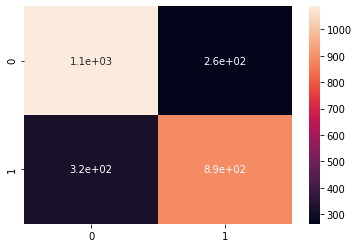

In [37]:
cf_matrix = confusion_matrix(test_y, RF_predictions)
sns.heatmap(cf_matrix, annot=True)

In [38]:
print(classification_report(test_y, RF_predictions))

              precision    recall  f1-score   support

           0       0.77      0.80      0.79      1351
           1       0.77      0.74      0.75      1208

    accuracy                           0.77      2559
   macro avg       0.77      0.77      0.77      2559
weighted avg       0.77      0.77      0.77      2559



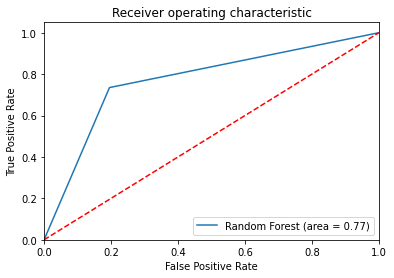

In [39]:
logit_roc_auc = roc_auc_score(test_y, RF_predictions)
fpr, tpr, thresholds = roc_curve(test_y, RF_predictions)
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [40]:
from sklearn import svm
clf = svm.SVC()
clf.fit(train_X, train_y)
result = clf.predict(test_X)
score = accuracy_score(test_y ,result)
print(score)

0.7932786244626807


In [41]:
print(clf)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


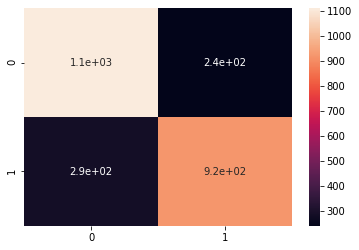

In [42]:
cf_matrix = confusion_matrix(test_y, result)
sns.heatmap(cf_matrix, annot=True)

In [43]:
print(classification_report(test_y, result))

              precision    recall  f1-score   support

           0       0.79      0.82      0.81      1351
           1       0.79      0.76      0.78      1208

    accuracy                           0.79      2559
   macro avg       0.79      0.79      0.79      2559
weighted avg       0.79      0.79      0.79      2559



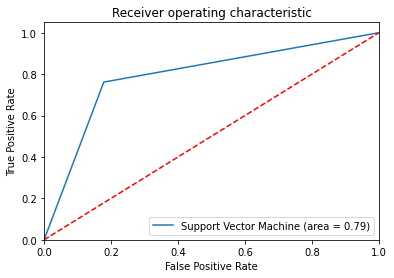

In [44]:
logit_roc_auc = roc_auc_score(test_y, result)
fpr, tpr, thresholds = roc_curve(test_y, result)
plt.figure()
plt.plot(fpr, tpr, label='Support Vector Machine (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [45]:
from sklearn.linear_model import *
logreg = LogisticRegression()
logreg.fit(train_X, train_y)
print(logreg)
y_pred = logreg.predict(test_X)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(test_X, test_y)))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Accuracy of logistic regression classifier on test set: 0.75


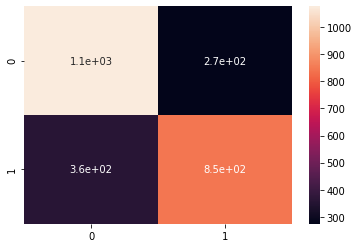

In [46]:
cf_matrix = confusion_matrix(test_y, y_pred)
sns.heatmap(cf_matrix, annot=True)

In [47]:
print(classification_report(test_y, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.80      0.77      1351
           1       0.76      0.70      0.73      1208

    accuracy                           0.75      2559
   macro avg       0.75      0.75      0.75      2559
weighted avg       0.75      0.75      0.75      2559



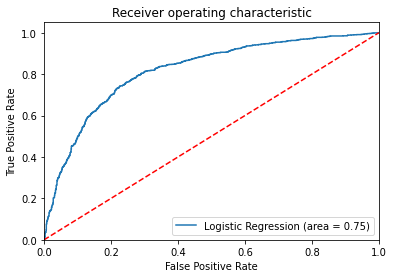

In [48]:
logit_roc_auc = roc_auc_score(test_y, logreg.predict(test_X))
fpr, tpr, thresholds = roc_curve(test_y, logreg.predict_proba(test_X)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [49]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB(class_prior=[.5,.5])
mnb.fit(train_X,train_y)
print(mnb)
y_pred = mnb.predict(test_X)

MultinomialNB(alpha=1.0, class_prior=[0.5, 0.5], fit_prior=True)


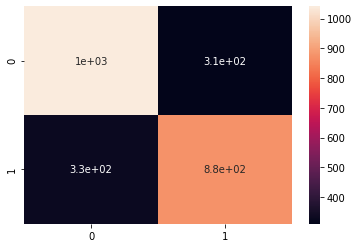

In [50]:
cf_matrix = confusion_matrix(test_y, y_pred)
sns.heatmap(cf_matrix, annot=True)

In [51]:
print(classification_report(test_y, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.77      0.76      1351
           1       0.74      0.73      0.73      1208

    accuracy                           0.75      2559
   macro avg       0.75      0.75      0.75      2559
weighted avg       0.75      0.75      0.75      2559



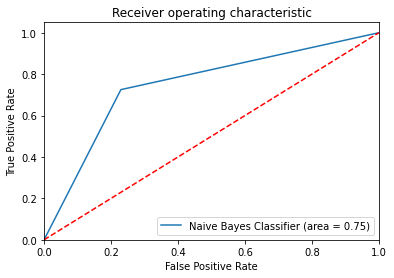

In [52]:
logit_roc_auc = roc_auc_score(test_y, y_pred)
fpr, tpr, thresholds = roc_curve(test_y, y_pred)
plt.figure()
plt.plot(fpr, tpr, label='Naive Bayes Classifier (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [0]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier

clf = DecisionTreeClassifier(criterion="entropy", max_depth=20)

clf = clf.fit(train_X,train_y)

y_pred = clf.predict(test_X)

In [54]:
print(clf)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=20, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


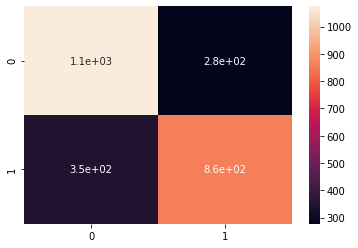

In [55]:
cf_matrix = confusion_matrix(test_y, y_pred)
sns.heatmap(cf_matrix, annot=True)

In [56]:
print(classification_report(test_y, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.79      0.77      1351
           1       0.76      0.71      0.73      1208

    accuracy                           0.76      2559
   macro avg       0.76      0.75      0.75      2559
weighted avg       0.76      0.76      0.76      2559



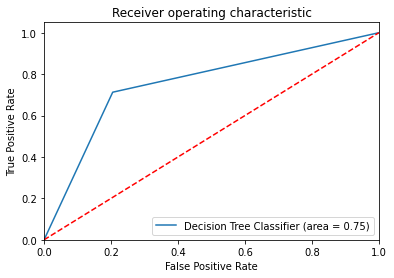

In [57]:
logit_roc_auc = roc_auc_score(test_y, y_pred)
fpr, tpr, thresholds = roc_curve(test_y, y_pred)
plt.figure()
plt.plot(fpr, tpr, label='Decision Tree Classifier (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [58]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 100)

y_pred = knn.fit(train_X, train_y)
score = knn.score(test_X, test_y)

print(score)

0.7342711996873779


In [59]:
!pip install xgboost

In [0]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [61]:
model = XGBClassifier()
model.fit(train_X, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [62]:
y_pred = model.predict(test_X)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(test_y, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 76.83%


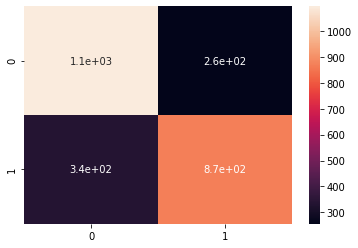

In [63]:
cf_matrix = confusion_matrix(test_y, y_pred)
sns.heatmap(cf_matrix, annot=True)

In [64]:
print(classification_report(test_y, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.81      0.79      1351
           1       0.77      0.72      0.75      1208

    accuracy                           0.77      2559
   macro avg       0.77      0.77      0.77      2559
weighted avg       0.77      0.77      0.77      2559



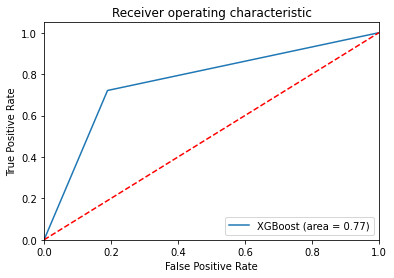

In [65]:
logit_roc_auc = roc_auc_score(test_y, y_pred)
fpr, tpr, thresholds = roc_curve(test_y, y_pred)
plt.figure()
plt.plot(fpr, tpr, label='XGBoost (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [0]:
# Build a neural network :
NN_model = Sequential()
NN_model.add(Dense(64, input_dim = input_dim, activation='relu'))
NN_model.add(Dropout(0.1))
NN_model.add(Dense(20, activation='relu'))
NN_model.add(Dropout(0.1))
NN_model.add(Dense(20, activation='relu'))
NN_model.add(Dropout(0.1))
NN_model.add(Dense(2, activation='softmax'))
NN_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
mc = ModelCheckpoint('best_model8.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
callbacks_list = [es, mc]
history = NN_model.fit(train_X, train_y, epochs=100, batch_size=16, validation_split = 0.2,callbacks=[es, mc])

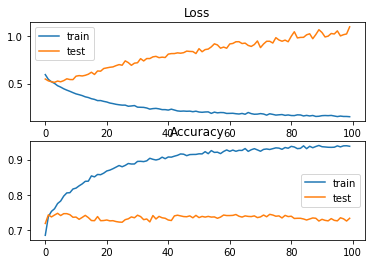

In [89]:
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [96]:
!pip install keras-tuner

     |████████████████████████████████| 61kB 4.7MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-cp36-none-any.whl size=73200 sha256=42c1bc6fa100b51cb90c5b5d37c9806bdcebcd55858be0698521b039c18709b6
  Stored in directory: /root/.cache/pip/wheels/b9/cc/62/52716b70dd90f3db12519233c3a93a5360bc672da1a10ded43
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=ffed1dbfb0540fbe9554b8356f3f30a250b39fc5c819b0e264eb2db7c697109d
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [0]:
# from kerastuner.tuners import RandomSearch
# from kerastuner.engine.hyperparameters import HyperParameters

In [0]:
# def build_model(hp):  # random search passes this hyperparameter() object 
#     model = Sequential()
#     model.add(Dense(64, input_dim = input_dim, activation='relu'))

#     for i in range(hp.Int('n_layers', 1, 5)):  
#         model.add(Dense(hp.Int(f'dense_{i}_units',
#                                 min_value=32,
#                                 max_value=256,
#                                 step=8)))
#         model.add(Activation('relu'))

#     # model.add(Flatten()) 
#     model.add(Dense(2))
#     model.add(Activation("softmax"))

#     model.compile(optimizer="adam",
#                   loss="sparse_categorical_crossentropy",
#                   metrics=["accuracy"])
    
#     return model

In [0]:
# tuner = RandomSearch(
#     build_model,
#     objective='val_accuracy',
#     max_trials=20, 
#     executions_per_trial=1,
# )

In [0]:
# tuner.search_space_summary()

In [0]:
# tuner.search(x=train_X,
#              y=train_y,
#              verbose=2, 
#              epochs=50,
#              batch_size=128,
#              validation_data=(test_X, test_y))